# 1) Setup & Imports


In [1]:
# Install and import libraries
!pip install -q numpy pandas matplotlib seaborn scikit-learn joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, GridSearchCV, learning_curve)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
import joblib

sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (10, 6)

OUT_DIR = 'iris_project_outputs'
os.makedirs(OUT_DIR, exist_ok=True)


# 2) Load Dataset and Preview

In [2]:
# Load the Iris dataset

iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
df['species'] = pd.Categorical.from_codes(y, target_names)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# 3) Exploratory Data Analysis (EDA)

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  

Class distribution:
 species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


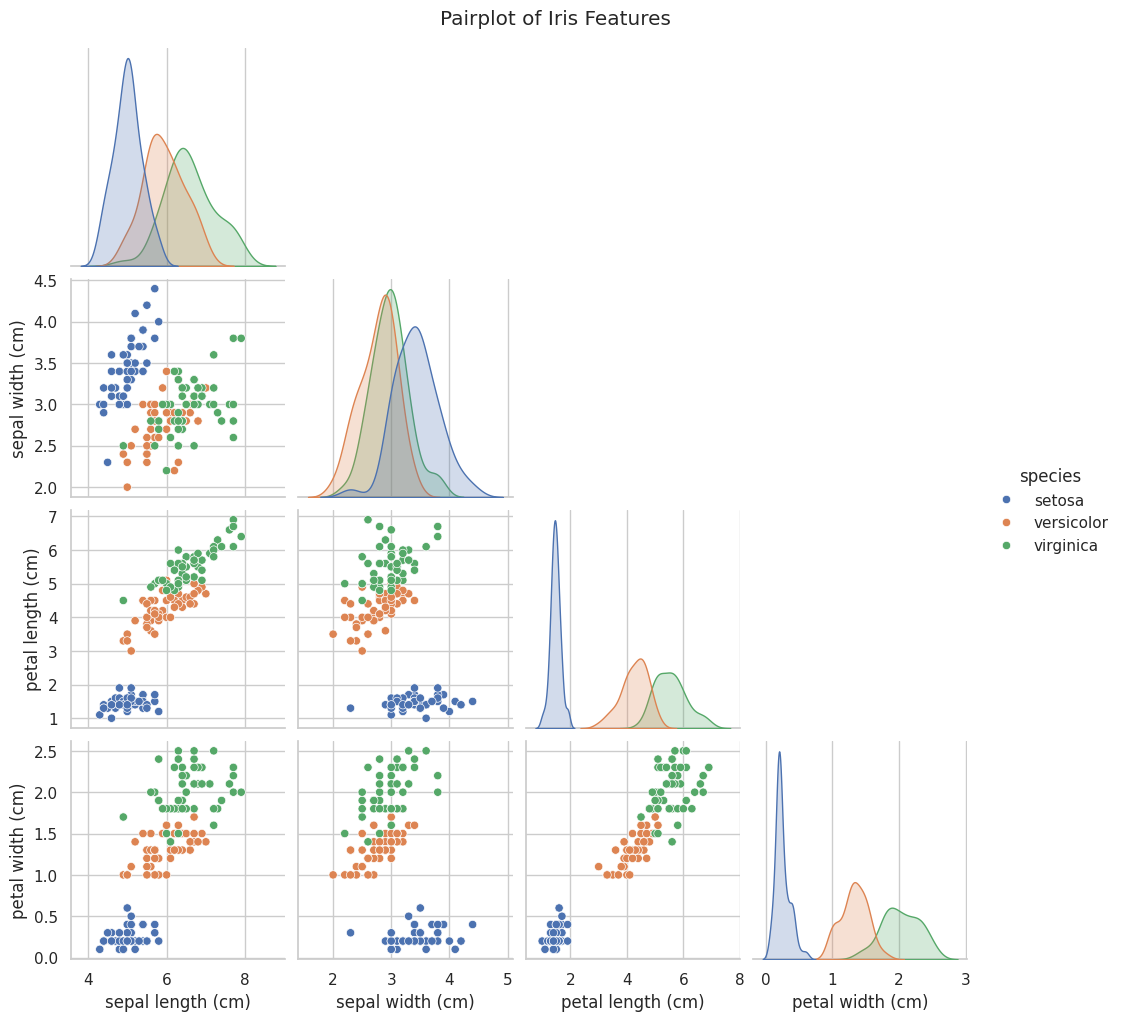

In [3]:
# Basic stats

print(df.describe())
print("\nClass distribution:\n", df['species'].value_counts())

# Pairplot
sns.pairplot(df, hue='species', corner=True)
plt.suptitle('Pairplot of Iris Features', y=1.02)
plt.show()

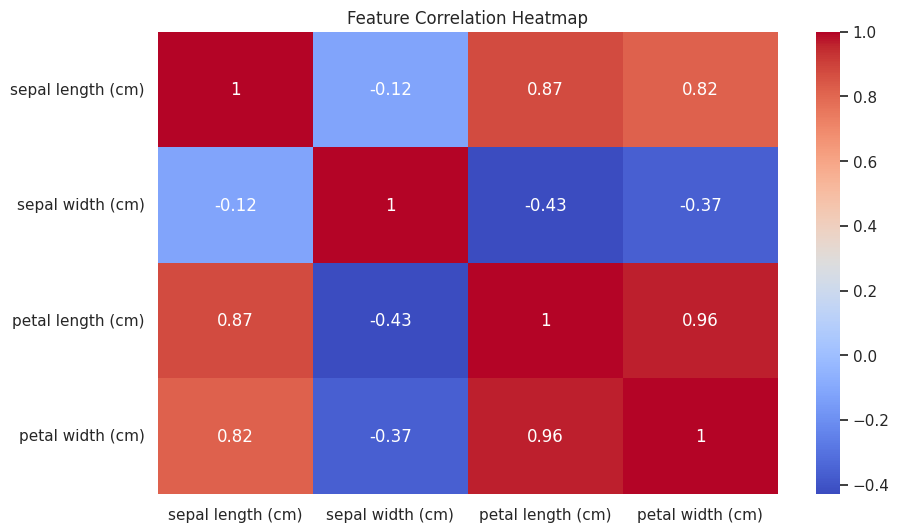

In [4]:
# Correlation heatmap
plt.figure()
sns.heatmap(df.iloc[:, :4].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

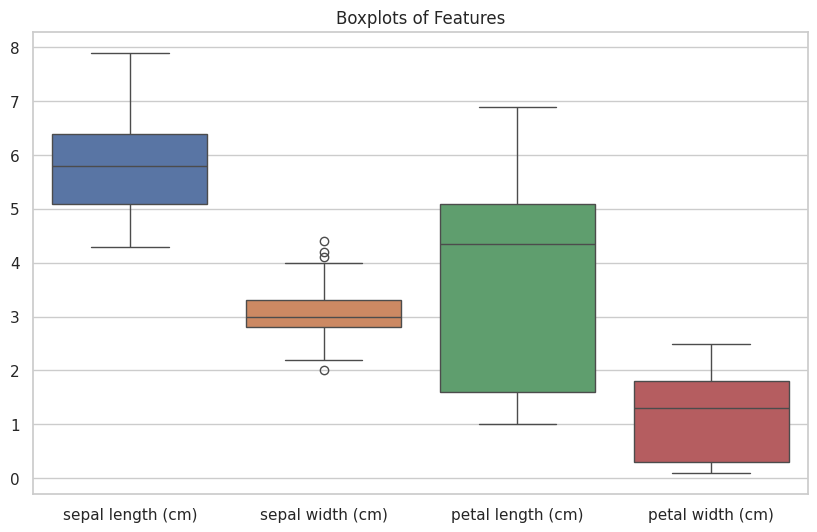

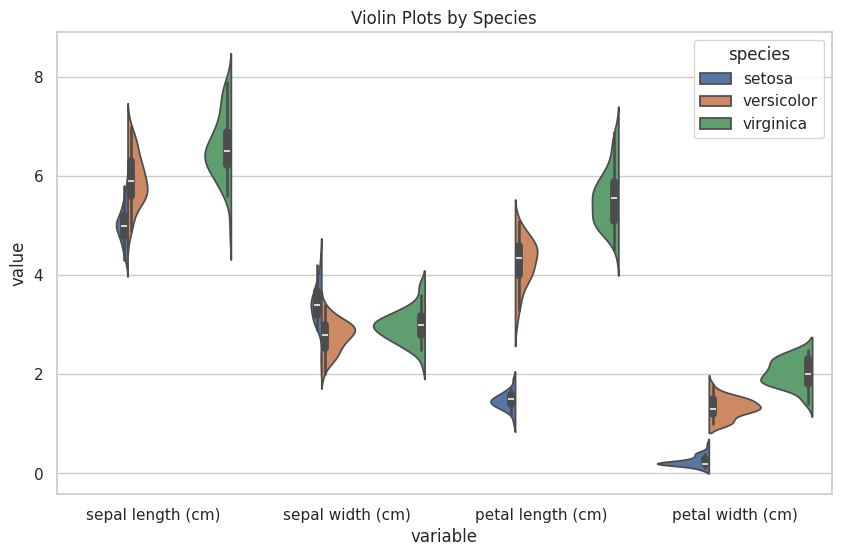

In [5]:
# Boxplots and Violin plots
sns.boxplot(data=df.iloc[:, :4])
plt.title('Boxplots of Features')
plt.show()

sns.violinplot(
    data=pd.melt(df, id_vars=['species'], value_vars=feature_names),
    x='variable', y='value', hue='species', split=True
)
plt.title('Violin Plots by Species')
plt.show()


# 4) Feature Scaling & Dimensionality Reduction (PCA, t-SNE)

Explained variance by 2 PCs: 95.81%


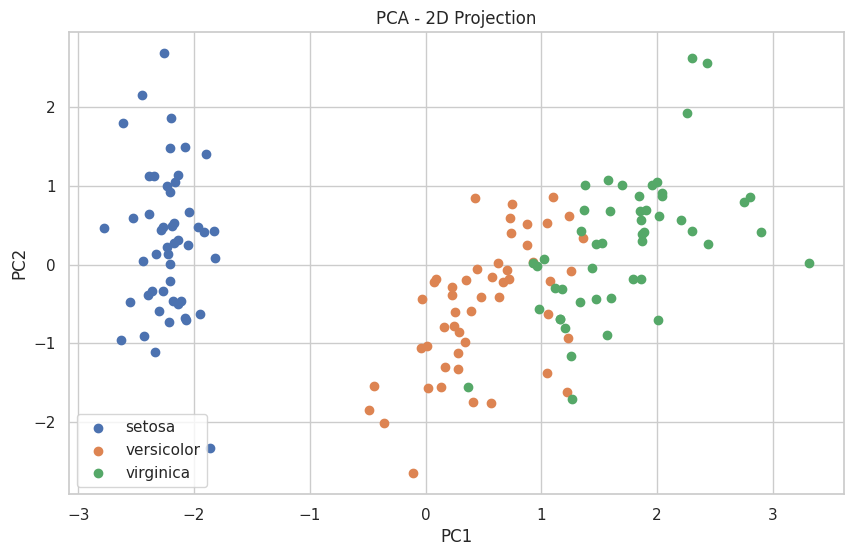

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance by 2 PCs: {:.2f}%".format(pca.explained_variance_ratio_.sum() * 100))

plt.figure()
for i, name in enumerate(target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=name)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.title("PCA - 2D Projection")
plt.show()

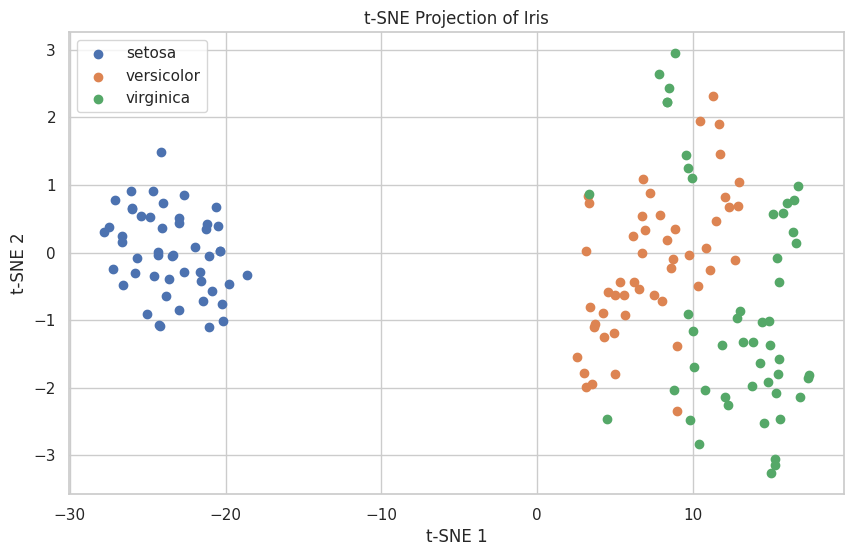

In [7]:
# t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_scaled)
plt.figure()
for i, name in enumerate(target_names):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], label=name)
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(); plt.title("t-SNE Projection of Iris")
plt.show()

# 5) Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 120 Test size: 30


# 6) Baseline Model Comparison (Cross-Validation)

In [9]:
def build_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

models = {
    'LogReg': LogisticRegression(max_iter=1000, random_state=42),
    'SVC_linear': SVC(kernel='linear', probability=True, random_state=42),
    'SVC_rbf': SVC(kernel='rbf', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    pipe = build_pipeline(model)
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy')
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")


LogReg: mean=0.953, std=0.045
SVC_linear: mean=0.967, std=0.052
SVC_rbf: mean=0.960, std=0.039
RandomForest: mean=0.947, std=0.027
GradientBoost: mean=0.953, std=0.034
KNN: mean=0.973, std=0.025
MLP: mean=0.947, std=0.054


# 7) Hyperparameter Tuning (RandomForest, SVC)

In [10]:
# RandomForest
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 3, 5],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(build_pipeline(RandomForestClassifier(random_state=42)),
                       param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best RF:", grid_rf.best_params_, "Score:", grid_rf.best_score_)

Best RF: {'model__max_depth': 3, 'model__min_samples_split': 2, 'model__n_estimators': 50} Score: 0.9583333333333334


In [11]:
# SVC (RBF)
param_grid_svc = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto']
}
grid_svc = GridSearchCV(build_pipeline(SVC(probability=True, random_state=42)),
                        param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)
print("Best SVC:", grid_svc.best_params_, "Score:", grid_svc.best_score_)

Best SVC: {'model__C': 1, 'model__gamma': 'scale'} Score: 0.9666666666666668


# 8) Final Evaluation


Best_RandomForest Accuracy: 0.967
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



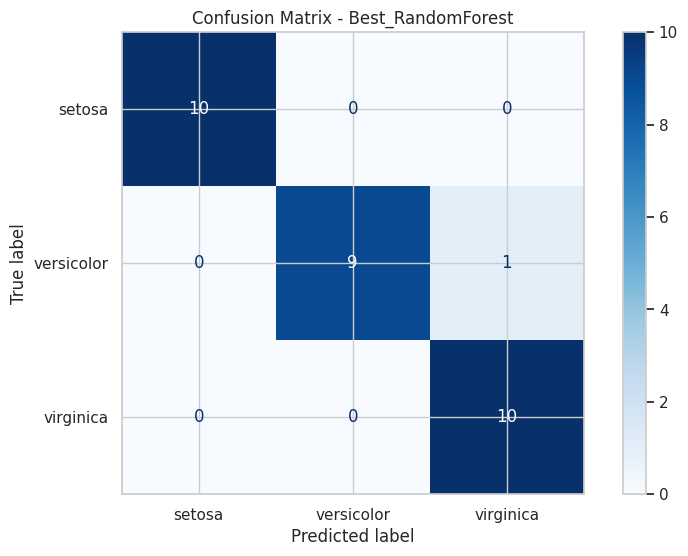


Best_SVC Accuracy: 0.967
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



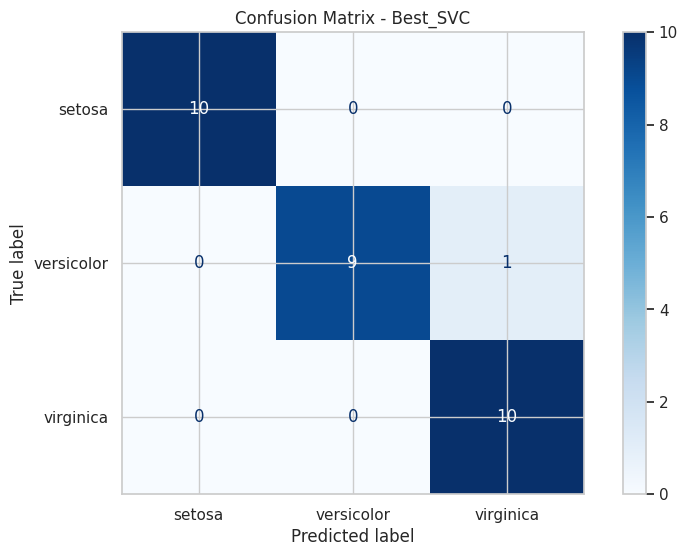


LogisticRegression Accuracy: 0.933
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



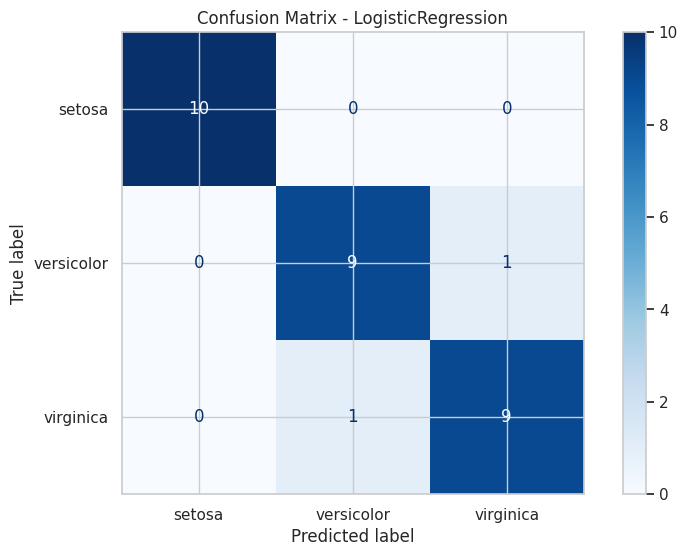

In [12]:
best_rf = grid_rf.best_estimator_
best_svc = grid_svc.best_estimator_

final_models = {
    'Best_RandomForest': best_rf,
    'Best_SVC': best_svc,
    'LogisticRegression': build_pipeline(LogisticRegression(max_iter=1000, random_state=42))
}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# 9) ROC Curves (Multi-Class)

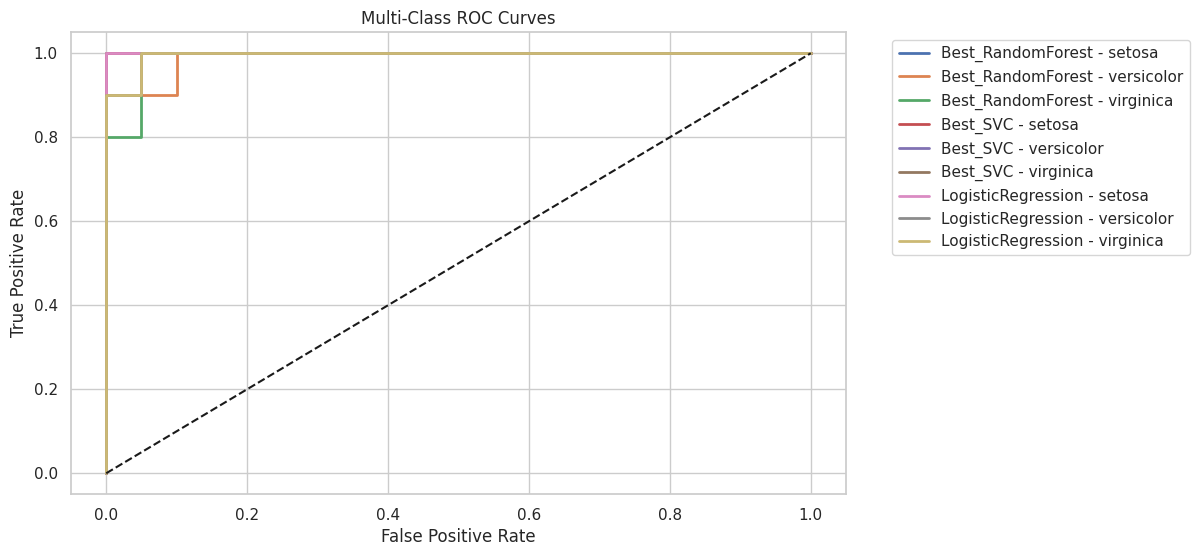

In [13]:
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure()

for name, model in final_models.items():
    try:
        y_score = model.predict_proba(X_test)
        for i in range(3):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f'{name} - {target_names[i]}')
    except:
        print(f"{name} skipped (no probas)")

plt.plot([0,1],[0,1],'k--')
plt.title('Multi-Class ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


# 10) Learning Curve & Feature Importances

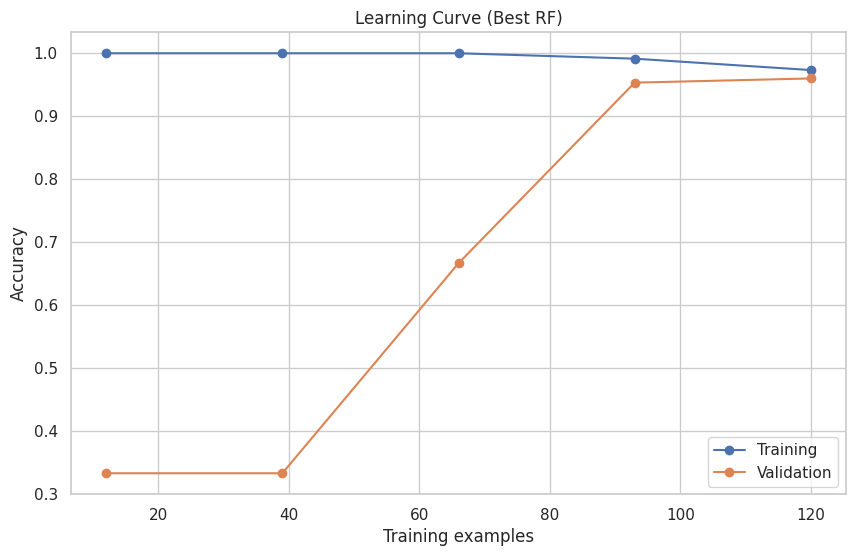

In [14]:
# Learning curve for best RF
train_sizes, train_scores, test_scores = learning_curve(best_rf, X, y, cv=5, n_jobs=-1)
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation')
plt.title("Learning Curve (Best RF)")
plt.xlabel("Training examples"); plt.ylabel("Accuracy"); plt.legend();
plt.show()

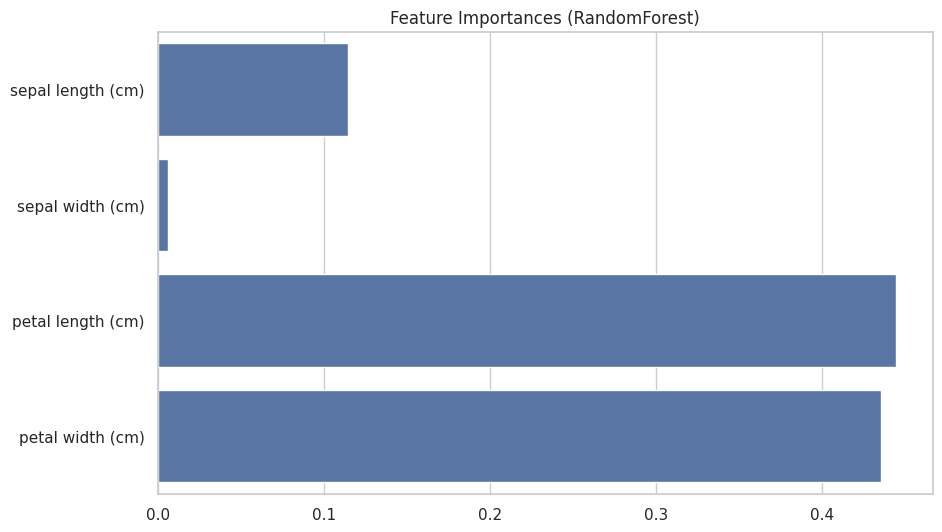

In [15]:
# Feature importances
rf_model = best_rf.named_steps['model']
importances = rf_model.feature_importances_
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances (RandomForest)")
plt.show()

# 11) Save Models

In [16]:
joblib.dump(best_rf, 'best_random_forest.joblib')
joblib.dump(best_svc, 'best_svc.joblib')
print("Models saved to working directory.")

Models saved to working directory.


In [17]:
!pip install streamlit pyngrok --quiet

In [18]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import joblib

# ---------------------------------------------------
# 1️⃣ App Configuration
# ---------------------------------------------------
st.set_page_config(
    page_title="🌸 Iris ML Dashboard",
    page_icon="🌺",
    layout="wide"
)
st.title("🌸 Iris Flower Classification & Visualization")
st.markdown("An interactive data science dashboard built with **Streamlit** to explore, visualize, and predict Iris species.")

# ---------------------------------------------------
# 2️⃣ Load Data
# ---------------------------------------------------
@st.cache_data
def load_data():
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = pd.Series(iris.target)
    df = X.copy()
    df['species'] = pd.Categorical.from_codes(y, iris.target_names)
    return df, iris

df, iris = load_data()

# ---------------------------------------------------
# 3️⃣ Sidebar Navigation
# ---------------------------------------------------
menu = st.sidebar.radio(
    "📊 Choose Section",
    ["🏠 Home", "🔍 Data Exploration", "📈 Visualizations", "🤖 Model Training", "🎯 Predict"]
)

# ---------------------------------------------------
# 🏠 HOME
# ---------------------------------------------------
if menu == "🏠 Home":
    st.subheader("Welcome to the Iris ML Web App 🌼")
    st.markdown("""
    **Project Features:**
    - Interactive EDA and visualizations
    - PCA dimensionality reduction
    - Random Forest-based classification
    - Real-time predictions
    - Clean, modern Streamlit UI
    """)

# ---------------------------------------------------
# 🔍 DATA EXPLORATION
# ---------------------------------------------------
elif menu == "🔍 Data Exploration":
    st.subheader("📋 Dataset Overview")
    st.dataframe(df.head())

    st.markdown("**Summary Statistics**")
    st.write(df.describe())

    st.markdown("**Class Distribution**")
    st.bar_chart(df['species'].value_counts())

# ---------------------------------------------------
# 📈 VISUALIZATIONS
# ---------------------------------------------------
elif menu == "📈 Visualizations":
    st.subheader("🌸 Feature Relationships & Patterns")

    col1, col2 = st.columns(2)
    with col1:
        st.markdown("**Pairplot**")
        sns.pairplot(df, hue="species", corner=True)
        st.pyplot(plt.gcf())
        plt.clf()

    with col2:
        st.markdown("**Correlation Heatmap**")
        plt.figure(figsize=(6, 4))
        sns.heatmap(df.iloc[:, :4].corr(), annot=True, cmap="coolwarm", fmt=".2f")
        st.pyplot(plt.gcf())
        plt.clf()

    st.markdown("**Boxplots by Feature**")
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=pd.melt(df, id_vars=["species"], value_vars=iris.feature_names),
                x="variable", y="value", hue="species")
    st.pyplot(plt.gcf())
    plt.clf()

    st.markdown("**PCA Visualization (2D)**")
    X = df.iloc[:, :4]
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    X_pca_df["species"] = df["species"]
    sns.scatterplot(data=X_pca_df, x="PC1", y="PC2", hue="species", s=100)
    st.pyplot(plt.gcf())
    plt.clf()

# ---------------------------------------------------
# 🤖 MODEL TRAINING
# ---------------------------------------------------
elif menu == "🤖 Model Training":
    st.subheader("Train and Evaluate a Random Forest Classifier 🌲")

    n_estimators = st.slider("Number of Trees", 10, 300, 100, 10)
    max_depth = st.slider("Maximum Tree Depth", 1, 10, 3)
    test_size = st.slider("Test Size (Proportion)", 0.1, 0.5, 0.2)

    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

    X = df.iloc[:, :4]
    y = df['species'].astype('category').cat.codes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    st.success(f"✅ Model trained successfully! Accuracy = **{acc:.3f}**")

    st.markdown("**Confusion Matrix:**")
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    st.pyplot(fig)

    st.markdown("**Classification Report:**")
    st.text(classification_report(y_test, y_pred, target_names=iris.target_names))

    # Save trained model
    joblib.dump(model, "iris_rf_model.joblib")

# ---------------------------------------------------
# 🎯 PREDICT
# ---------------------------------------------------
elif menu == "🎯 Predict":
    st.subheader("🌼 Predict Iris Flower Species")

    st.markdown("Enter flower measurements below:")
    sepal_length = st.number_input("Sepal Length (cm)", 4.0, 8.0, 5.8)
    sepal_width = st.number_input("Sepal Width (cm)", 2.0, 4.5, 3.0)
    petal_length = st.number_input("Petal Length (cm)", 1.0, 7.0, 4.3)
    petal_width = st.number_input("Petal Width (cm)", 0.1, 2.5, 1.3)

    input_data = np.array([[sepal_length, sepal_width, petal_length, petal_width]])

    # Load trained model or train a new one if not present
    try:
        model = joblib.load("iris_rf_model.joblib")
    except:
        model = RandomForestClassifier(random_state=42).fit(df.iloc[:, :4], df['species'].astype('category').cat.codes)

    pred_idx = model.predict(input_data)[0]
    pred_species = iris.target_names[pred_idx]

    st.success(f"🌸 Predicted Species: **{pred_species.capitalize()}**")

    # Feature importance
    st.markdown("**Feature Importance:**")
    importances = model.feature_importances_
    imp_df = pd.DataFrame({"Feature": iris.feature_names, "Importance": importances})
    sns.barplot(x="Importance", y="Feature", data=imp_df.sort_values("Importance", ascending=False))
    st.pyplot(plt.gcf())
    plt.clf()

Overwriting app.py


In [19]:
!pip install pyngrok --quiet
from pyngrok import ngrok
!ngrok config add-authtoken 34VADzTWUIxvmMrGEBiy0GsBBE5_2kGou76Cb1qvHrSJy2koL


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [20]:
from pyngrok import ngrok
# Kill old tunnels (avoid “address already in use”)
ngrok.kill()

# Start a new tunnel to the Streamlit port
public_url = ngrok.connect(addr=8501)
print("🌐 Public URL:", public_url)

# Launch Streamlit app
!streamlit run app.py --server.port 8501 --server.headless true --browser.gatherUsageStats false


🌐 Public URL: NgrokTunnel: "https://astronomical-kohen-treasurable.ngrok-free.dev" -> "http://localhost:8501"

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.15.159:8501

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
  Stopping...
  Stopping...
